In [14]:
# Import
import pandas as pd
import darts
from darts import TimeSeries
from darts.models import ExponentialSmoothing, ARIMA, Prophet
import matplotlib.pyplot as plt
from darts.utils.utils import SeasonalityMode
from darts.utils.statistics import plot_acf, plot_pacf, check_seasonality, extract_trend_and_seasonality, ModelMode, remove_trend, remove_from_series
import glob 
import os
from darts.utils.missing_values import fill_missing_values


In [15]:
# Merging all files and making the dataframe
#df = pd.concat(map(pd.read_csv, glob.glob(os.path.join("./data" , "*.csv"))), ignore_index= True)
df = pd.read_csv('data/0.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')

# Check the existent of nan values 
if df['value'].isna().sum() != 0 :
    df['value'] = fill_mising_values(df['value'])
else:
    print("No missing value")
    

No missing value


In [16]:
# Too long time series not supported
df = df.head(1000)

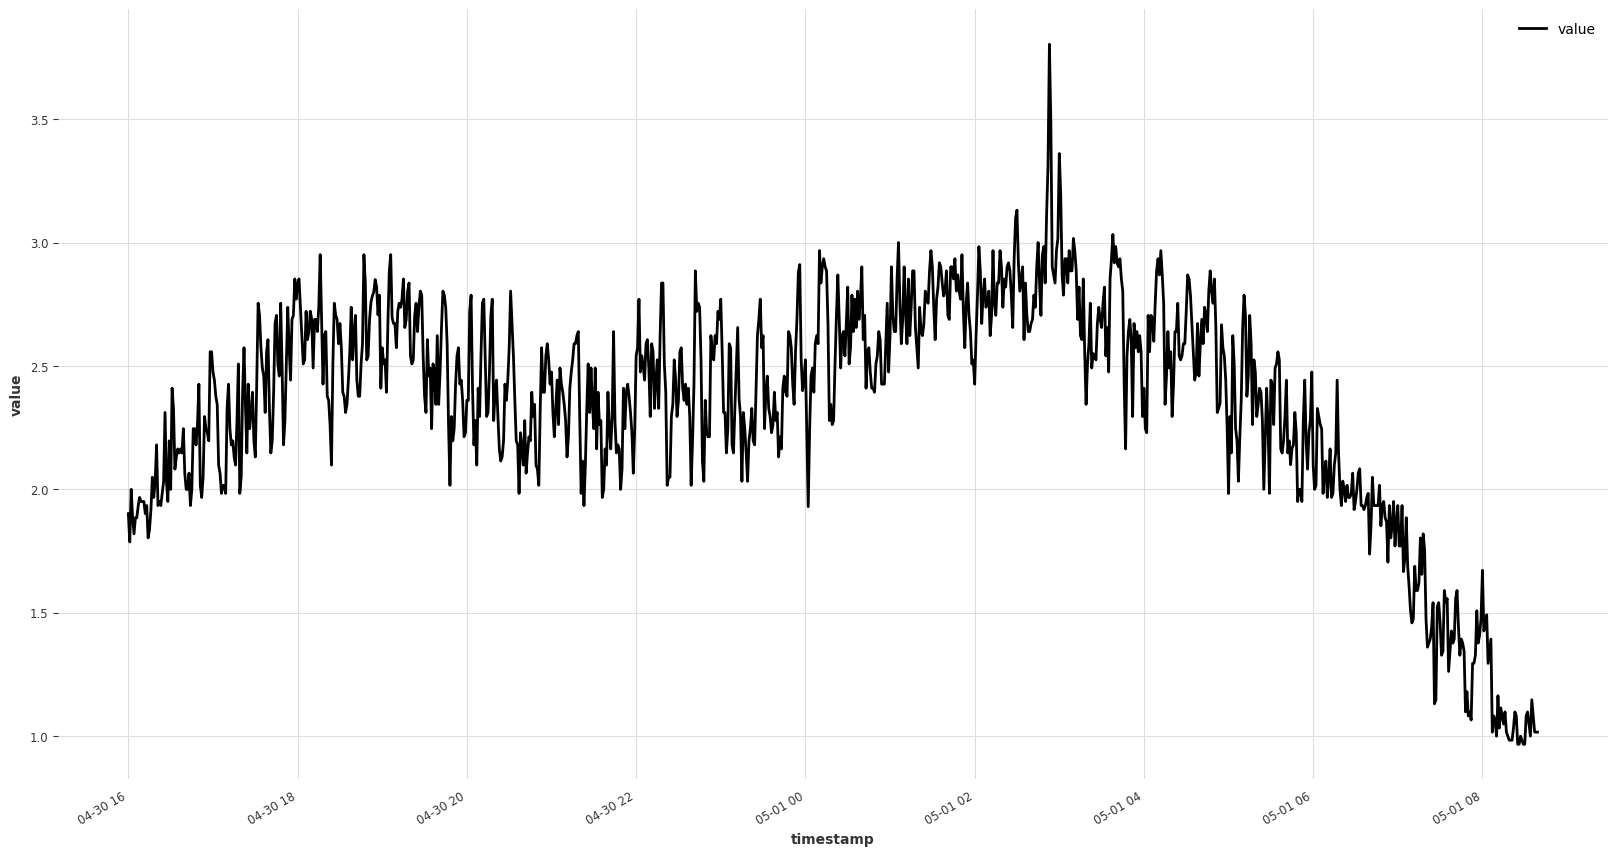

In [17]:
# Create a TimeSeries, specifying the time and value columns
series = TimeSeries.from_dataframe(df, 'timestamp', 'value', freq='T')
# Set aside the last 36 months as a validation series
train, val = series[:-round(len(df) / 5)], series[-round(len(df) / 5):]

# Plot the time series
plt.rcParams["figure.figsize"] = (20,10)
series.plot()
plt.ylabel("value")
plt.show()

In [18]:
# Check occurence of seasonality and find the period of it
is_sesonal, m = check_seasonality(ts = series, m = None, max_lag = 100, alpha = 0.05)
print(is_sesonal)
print(m)

True
27


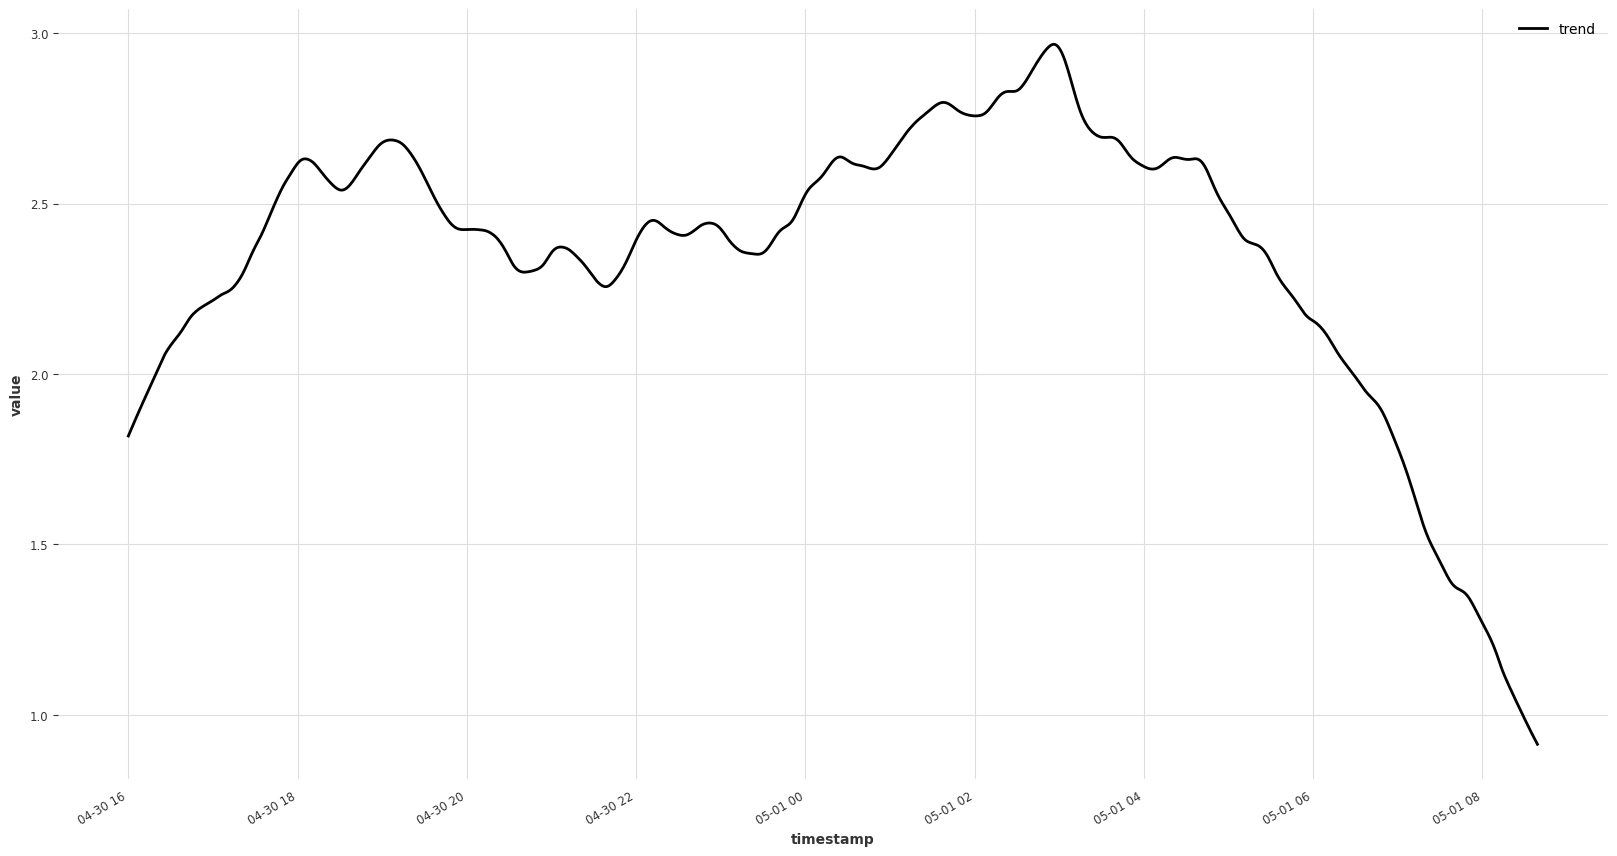

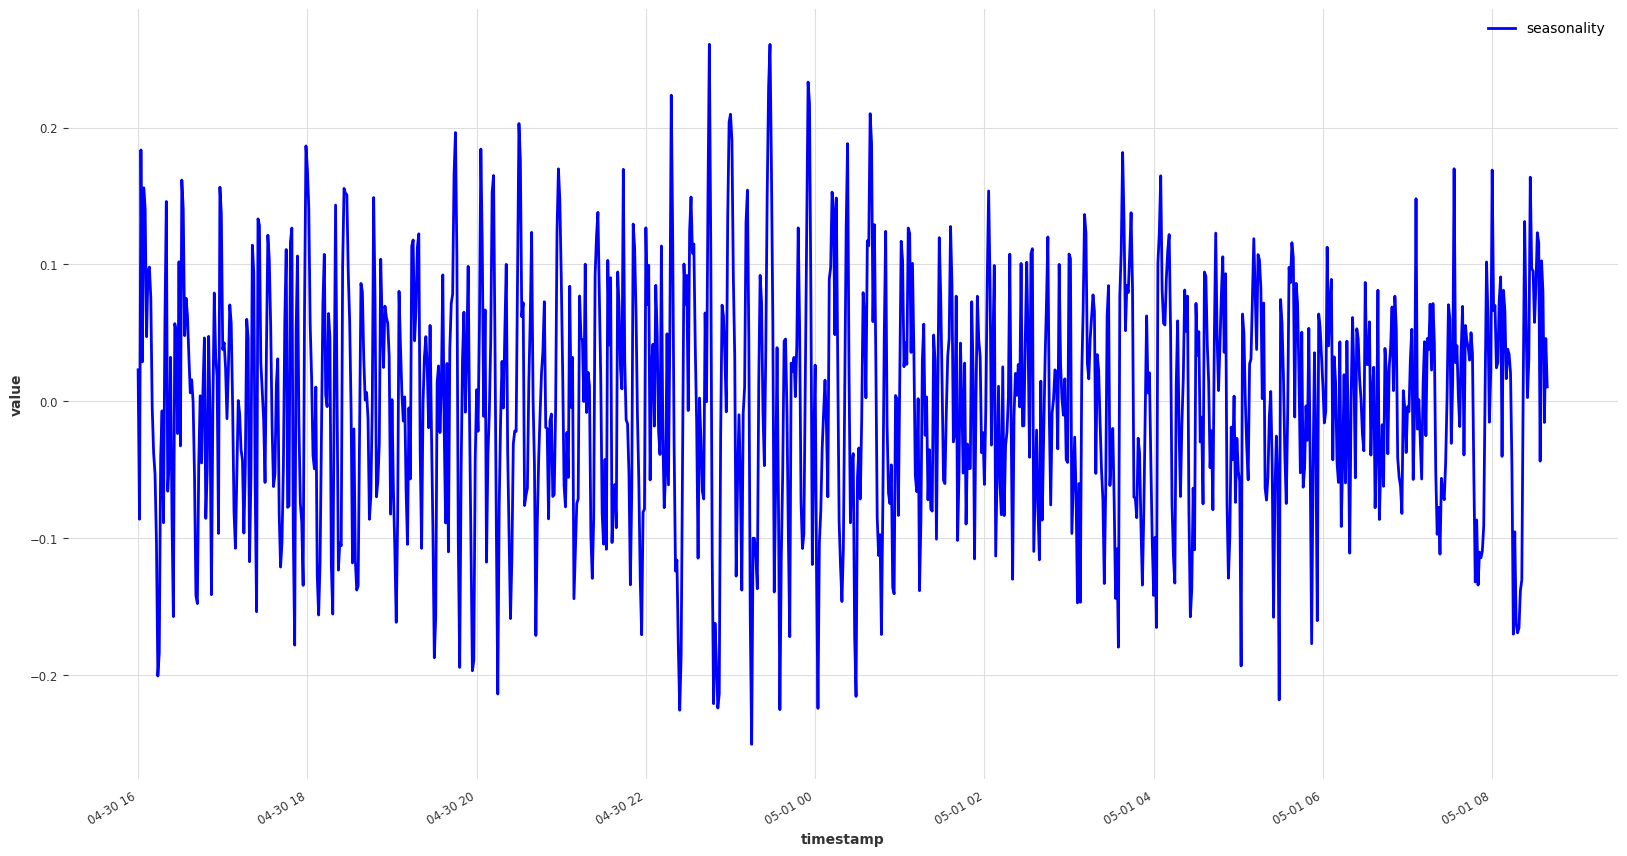

In [19]:
# Decompose trend and sesonality
trend,seasonality = extract_trend_and_seasonality(ts = series, model = ModelMode.ADDITIVE, method = "STL", freq = m)

trend.plot(label = "trend")
plt.ylabel("value")
plt.legend()
plt.show()


seasonality.plot(label = "seasonality", color = "blue")
plt.ylabel("value")
plt.show()


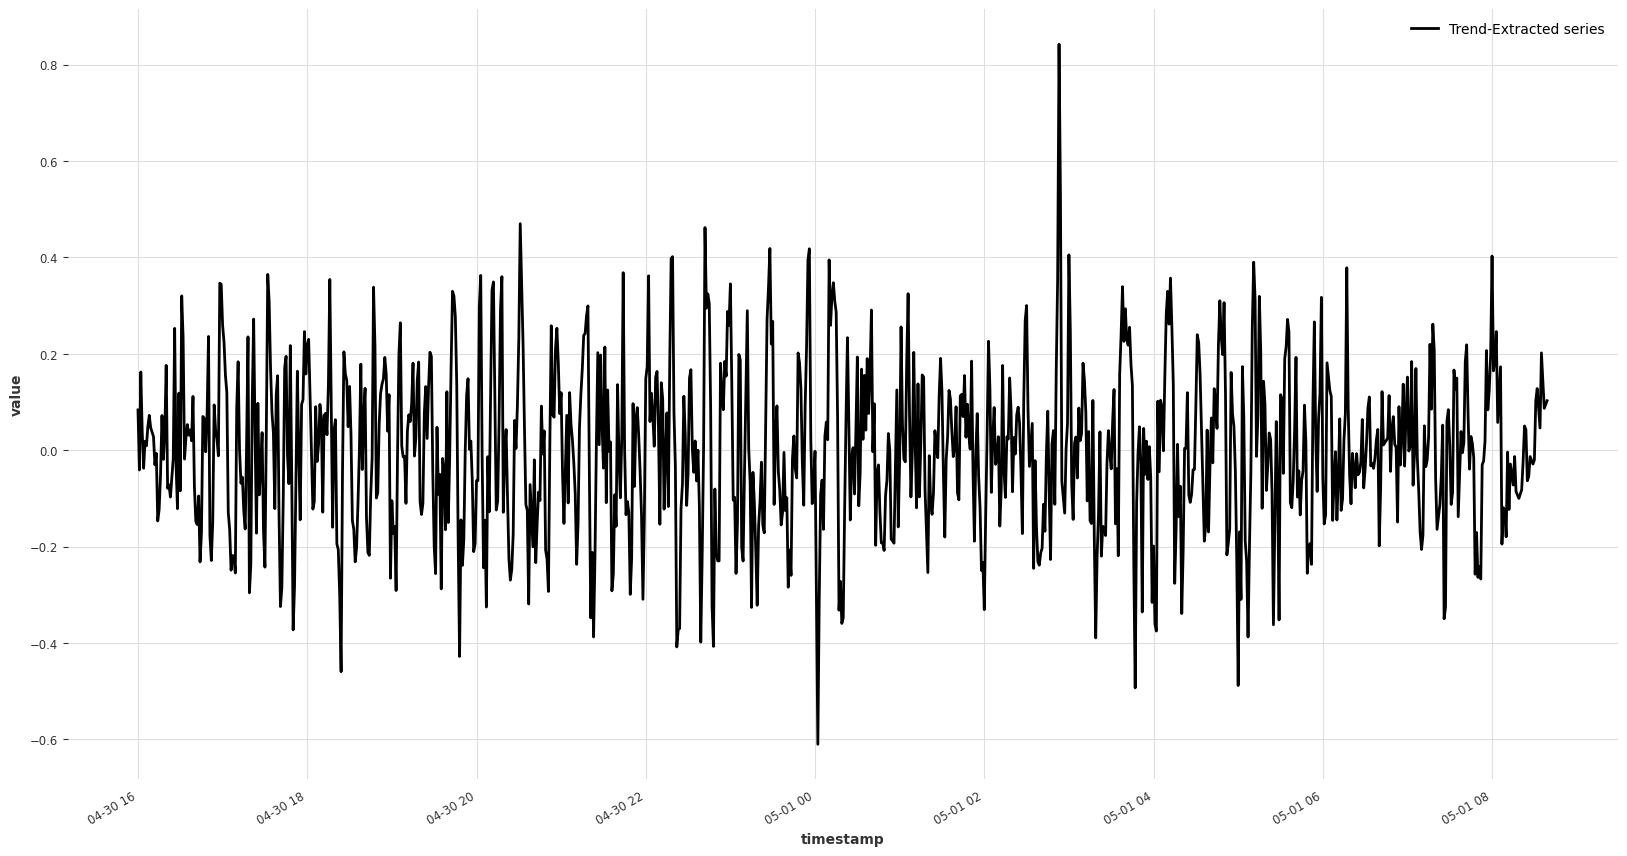

In [20]:
# Extract trend
series_minus_trend = remove_from_series(ts = series, other = trend, model = ModelMode.ADDITIVE )
series_minus_trend.plot(label = "Trend-Extracted series")
plt.ylabel("value")
plt.show()

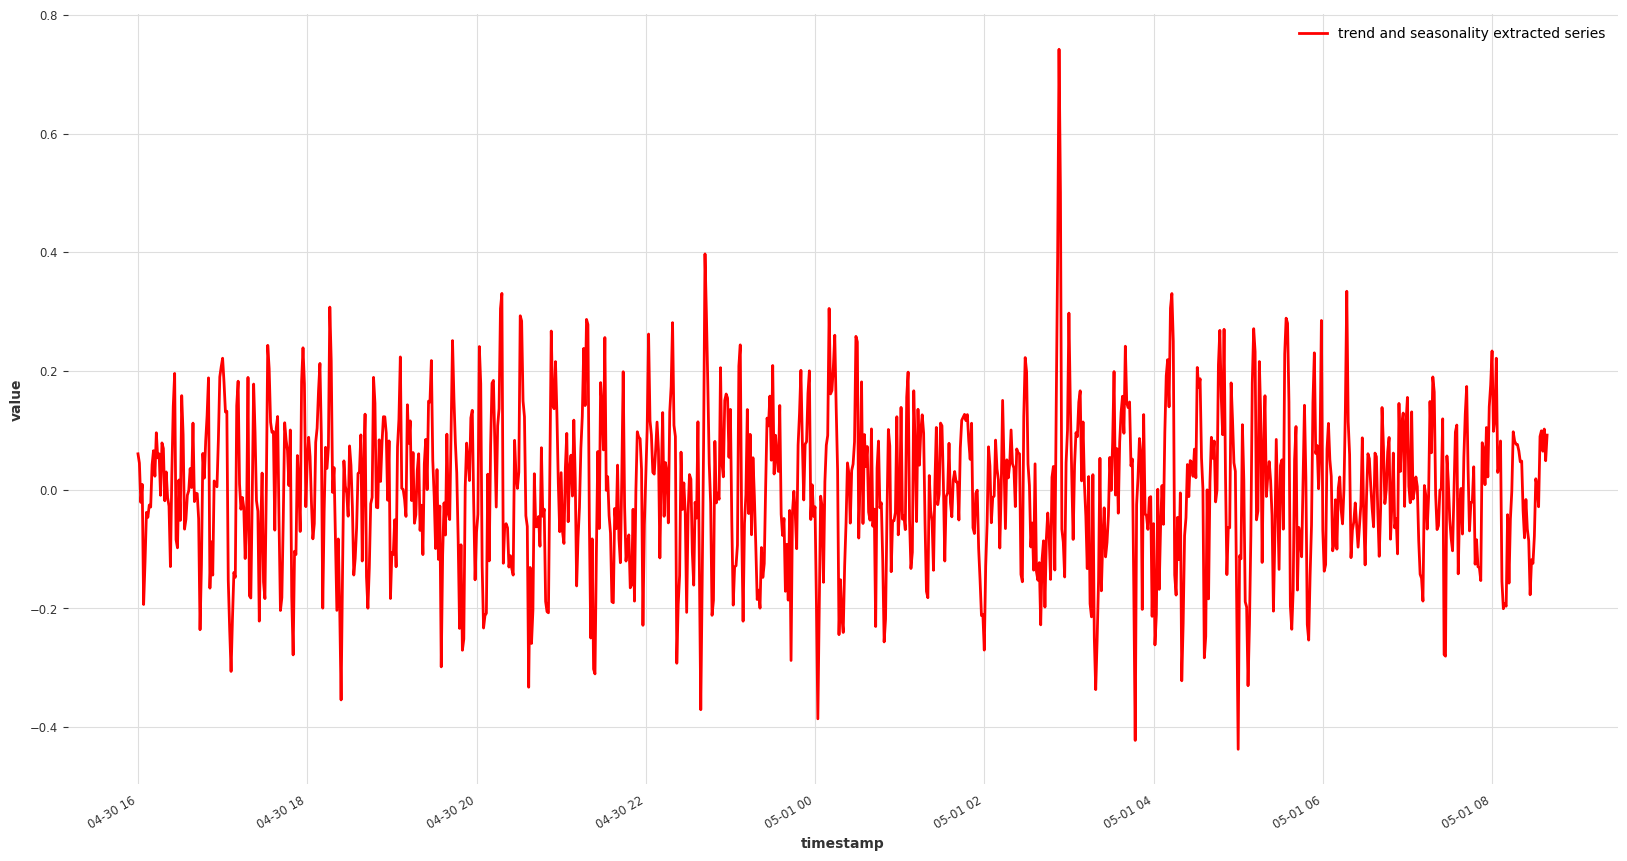

In [27]:
# Extract seasonality
series_minus_trend_and_sesonality = remove_from_series(ts = series_minus_trend, other = seasonality, model = ModelMode.ADDITIVE )
series_minus_trend_and_sesonality.plot(label = "trend and seasonality extracted series", color = "red")
plt.ylabel("value")
plt.show()

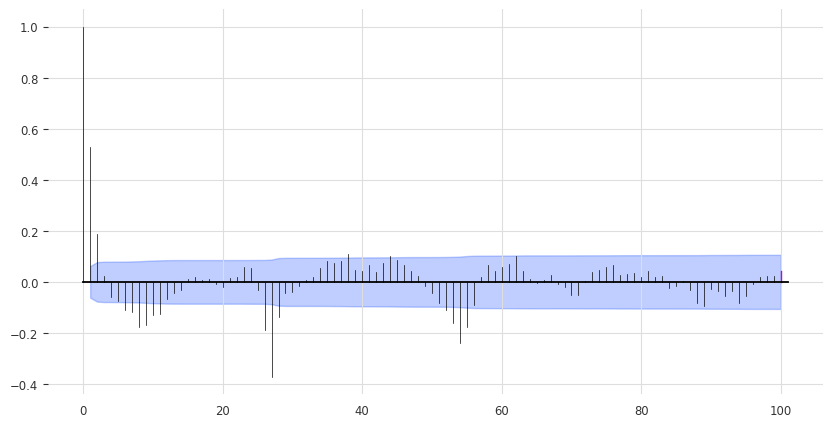

In [22]:
plot_acf(series, 100, max_lag=100)

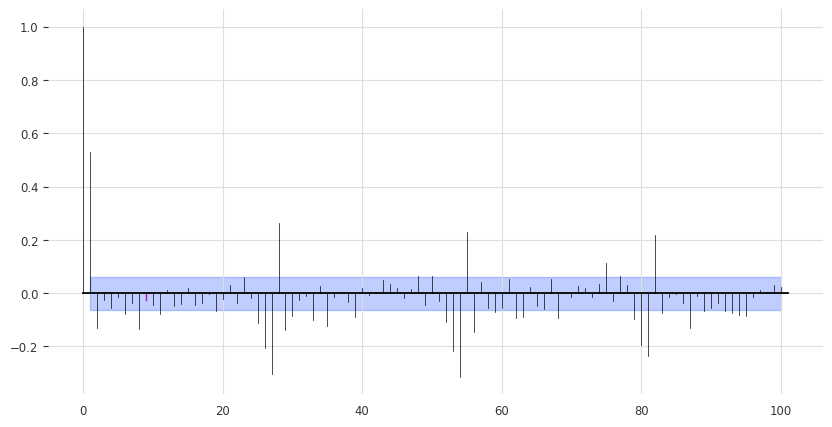

In [23]:
plot_pacf(series, 9, max_lag=100)

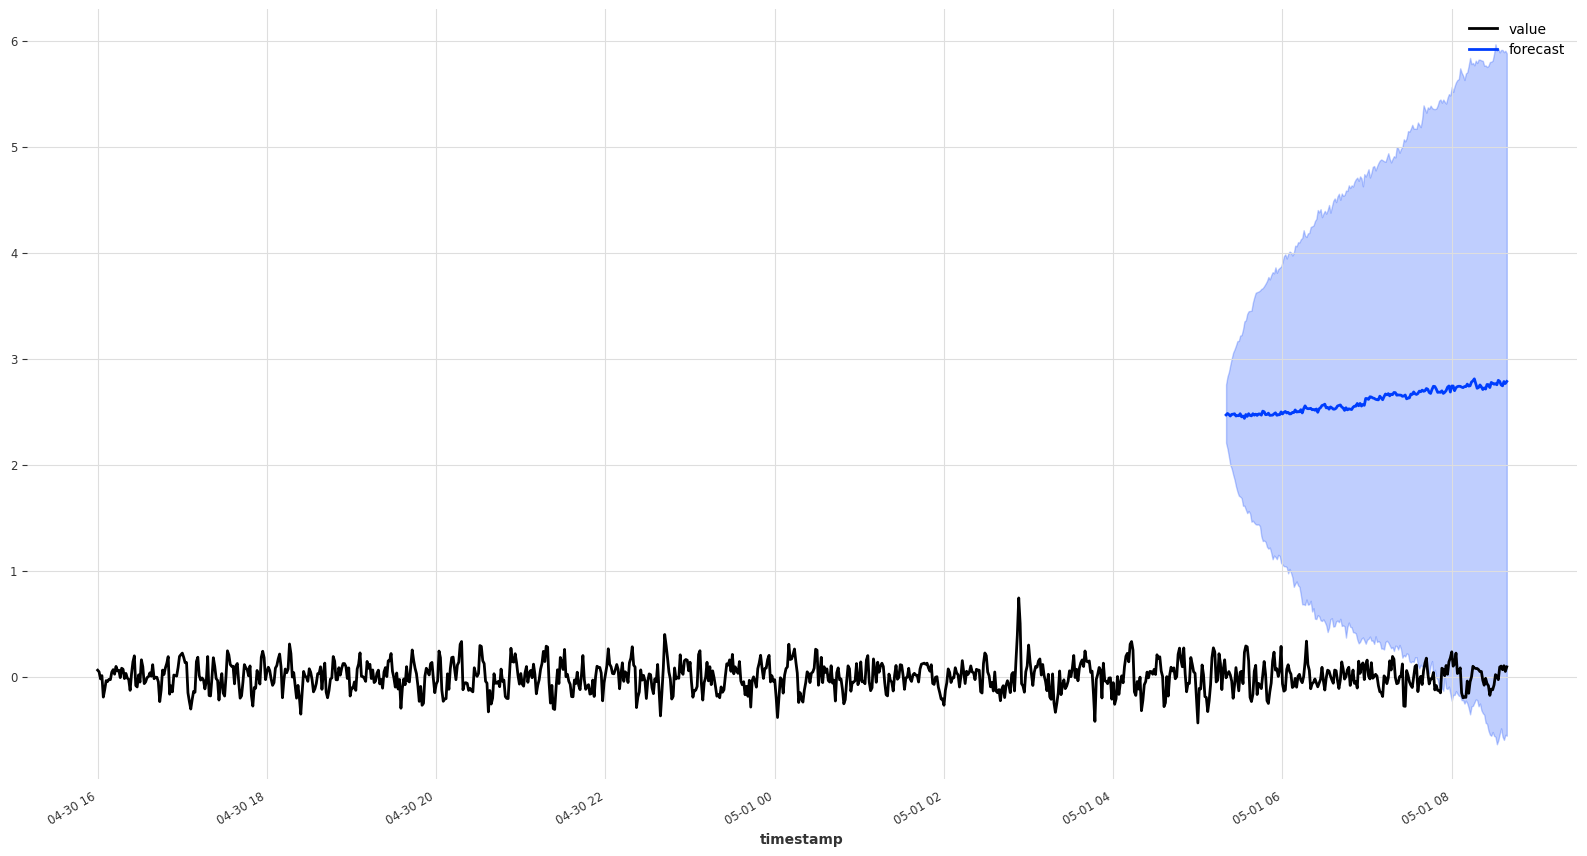

In [24]:
exp_model = ExponentialSmoothing(seasonal=SeasonalityMode.NONE)
exp_model.fit(train)
exp_prediction = exp_model.predict(len(val), num_samples=1000)
# Plotting the predictions
series.plot()
exp_prediction.plot(label='forecast', low_quantile=0.05, high_quantile=0.95)
plt.legend()

f:\datadays\github\env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
f:\datadays\github\env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
f:\datadays\github\env\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


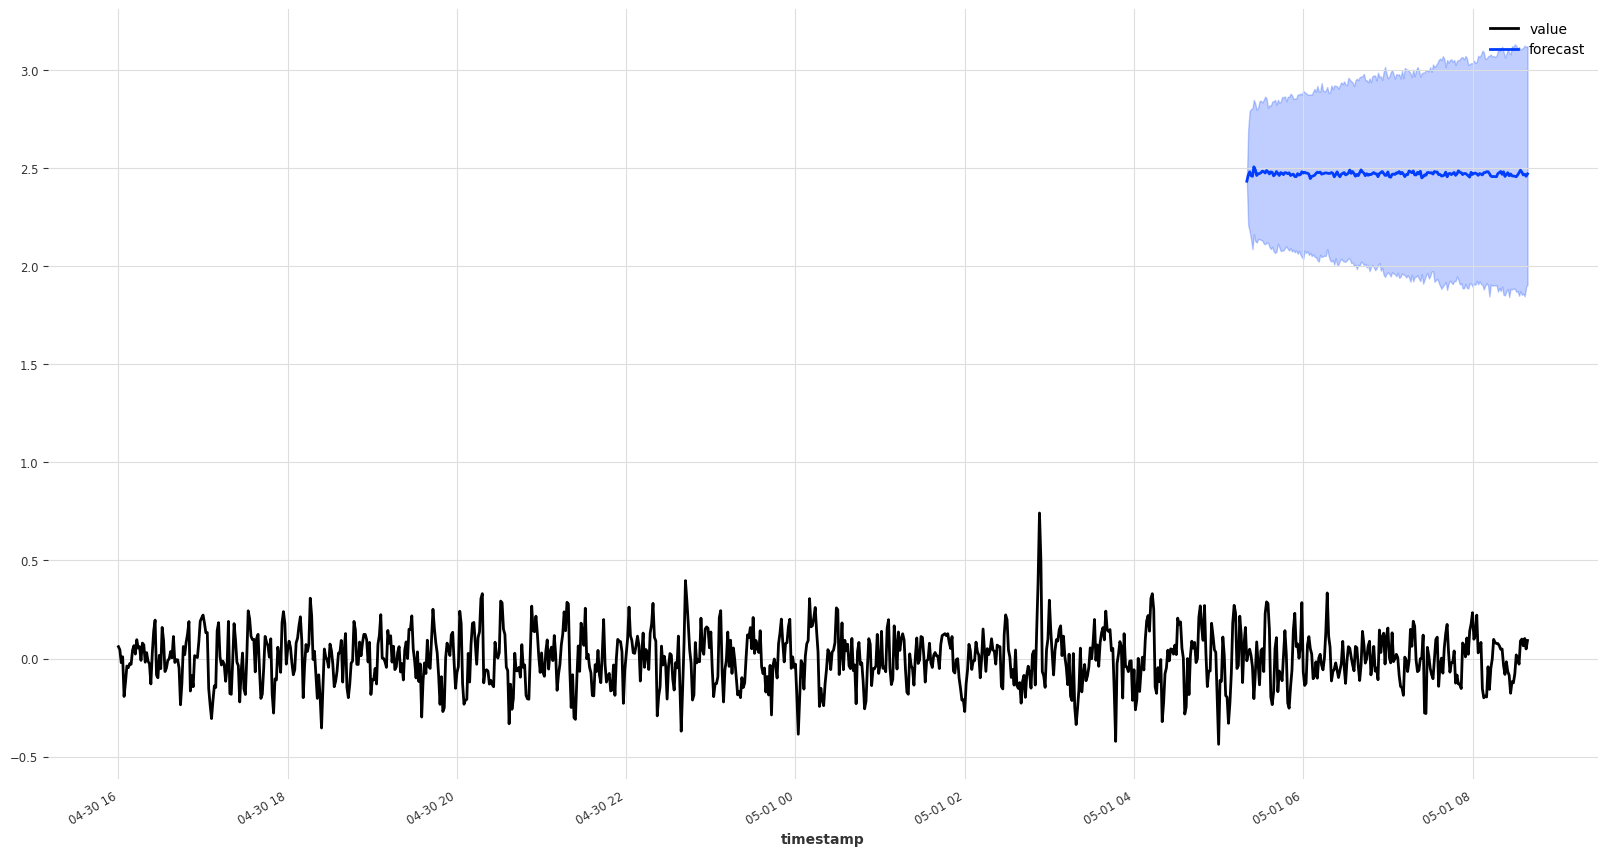

In [25]:
arima_model = ARIMA(9, 1, 5)
arima_model.fit(train)
arima_prediction = arima_model.predict(len(val), num_samples=1000)
# Plotting the predictions
series.plot()
arima_prediction.plot(label='forecast', low_quantile=0.05, high_quantile=0.95)
plt.legend()

2022-09-02 15:39:32 cmdstanpy DEBUG: cmd: where.exe tbb.dll
cwd: None
2022-09-02 15:39:34 cmdstanpy DEBUG: TBB already found in load path
2022-09-02 15:39:34 prophet INFO: Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
2022-09-02 15:39:34 prophet INFO: Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
2022-09-02 15:39:34 prophet INFO: Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
2022-09-02 15:39:35 cmdstanpy DEBUG: input tempfile: C:\Users\Pouria.N\AppData\Local\Temp\tmpa_nud1k2\n7l1zvnh.json
2022-09-02 15:39:35 cmdstanpy DEBUG: input tempfile: C:\Users\Pouria.N\AppData\Local\Temp\tmpa_nud1k2\bzd3e9sp.json
2022-09-02 15:39:35 cmdstanpy DEBUG: idx 0
2022-09-02 15:39:35 cmdstanpy DEBUG: running CmdStan, num_threads: None
2022-09-02 15:39:35 cmdstanpy DEBUG: CmdStan args: ['F:\\datadays\\github\\env\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random

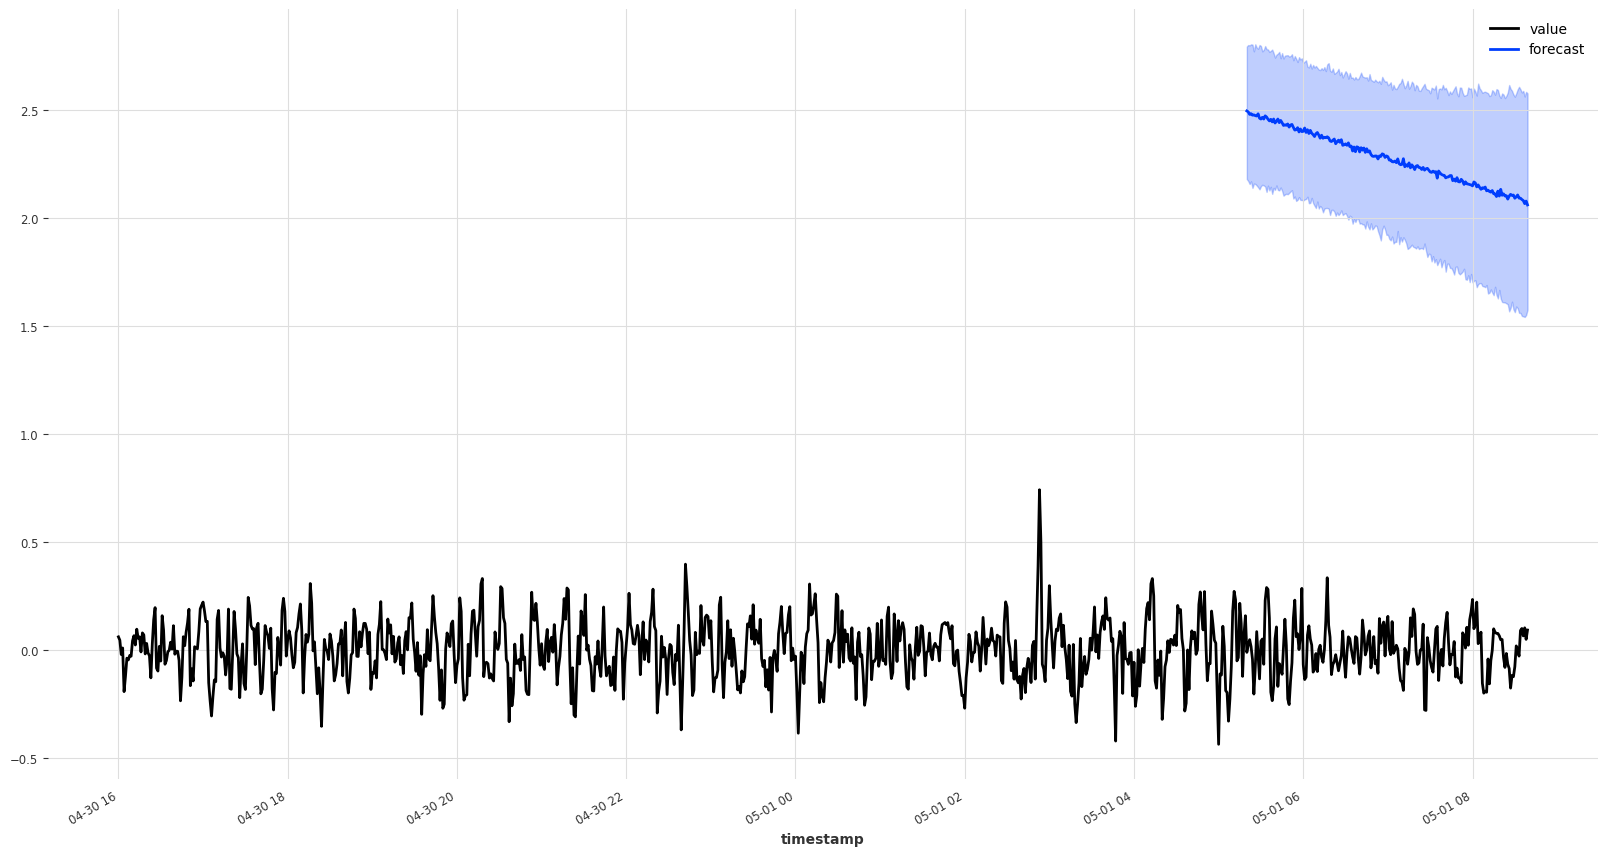

In [26]:
prophet_model = Prophet()
prophet_model.fit(train)
prophet_prediction = prophet_model.predict(len(val), num_samples=1000)
# Plotting the predictions
series.plot()
prophet_prediction.plot(label='forecast', low_quantile=0.05, high_quantile=0.95)
plt.legend()